In [1]:
import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math


# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# Initial parameters
baseline_ = 16000.0 * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [6]:
def process_waveform(pulse):
    """Very simple peakfinder. Returns a list of ch, pulse Q, width and start of pulse. 
    Q is in ADC counts and width and start of pulse are in sample counts relative to 
    start of event."""
    q, pe = 0, 0
    left_t, right_t = 0, 0
    ch = pulse.channel
    if ch not in det_ch['tpc']:
        return (-1, 0, 0, 0)
        
    ch = det_ch['tpc'].index(ch)
    wf = pulse.raw_data
    
    s = np.std(wf)
    delta = baseline_[ch] - np.min(wf)
    if min(s, delta) > 5*std_[ch]:
        accumulating = False
        first = True
        for samples in enumerate(wf):
            base_sub = samples[1]-baseline_[ch]
            #print(samples, " ", base_sub, " ", std, " ", q)
            if abs(base_sub) > 5*std_[ch] and samples[1] < 0.9*baseline_[ch]:
                q = q + base_sub
                if not accumulating and first:
                    left_t = samples[0]
                    accumulating = True
                    first = False
            else:
                if accumulating:
                    right_t = samples[0]
                    #accumulating = False
    else:
        baseline_[ch] = np.average(wf)
        std_[ch] = s
    width = right_t - left_t
    if width != 0 and -q/width < 3*std_[ch]:
        q = 0
#    if width != 0:
#        pe = q * 0.5/2**14 * 2 * 1e-9/(width * 1.6022e-19) * 2e-6 * -1
    return (ch, q, width, pulse.left+left_t)

In [9]:
%matplotlib inline
event = NG.get_single_event(4)

s1 = [0, 0]
s2 = [0, 0]
for p in event.pulses:
    (ch, q, width, t0) = process_waveform(p)
    if q < 0 and ch == 0:
        print(ch, ": ", q, width, t0)
        """
        if width < 1000: # Separate S1 from S2
            if s1[ch] == 0:
                s1[ch] = -q
            else:
                s2[ch] = s2[ch] - q # Sum all the S2
        """

0 :  -5212776.27451 2202 107271


In [12]:
# A waveform reader function
def Waveform(eventnr):
    event = NG.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        i = np.zeros(n_channels, dtype = int)
        #print(p.channel, ": ", p.left, p.right-p.left)
        for adc in p.raw_data:
            
            #Add the ADC value to the appropriate channel array
            ts[ch][p.left + i[ch]] = adc
            i[ch] = i[ch] + 1
            
            #Append all significant main channels to the list
            if adc < 15000 and ch not in channellist and ch in det_ch['tpc']:
                channellist.append(ch)
                
            #Check which channel is the minimum channel
            if adc < adcmin:
                adcmin = adc
                minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel

181 :  -253055.818182 774 107343
151 :  -164486.615385 796 107340
133 :  -70274.6272727 886 107360
127 :  -256158.769231 814 107337
146 :  -191833.526316 693 107339
153 :  -93235.1372549 830 107341
215 :  -279914.707317 719 107346
158 :  -280770.182692 710 107327
140 :  -227807.0 705 107342
132 :  -170500.134615 856 107343
170 :  -260480.134615 703 107339
177 :  -37848.1509434 724 107358
159 :  -53518.8823529 706 107362
180 :  -258069.313725 799 107343
204 :  -172898.0 730 107333
221 :  -134624.230769 786 107334
187 :  -106269.333333 605 107333
229 :  -139834.625 740 107342
90 :  -101487.735294 794 107351
64 :  -511226.921569 964 107317
136 :  -141216.696078 688 107348
173 :  -14750.6153846 655 107377
207 :  -50131.3529412 808 107364
143 :  -74570.8823529 755 107342
186 :  -116524.147059 826 107335
169 :  -235406.0 904 107334
210 :  -24144.7307692 700 107353
138 :  -211136.323529 660 107334
185 :  -127490.647059 755 107351
226 :  -74714.2745098 754 107330
175 :  -206715.558824 768 1073

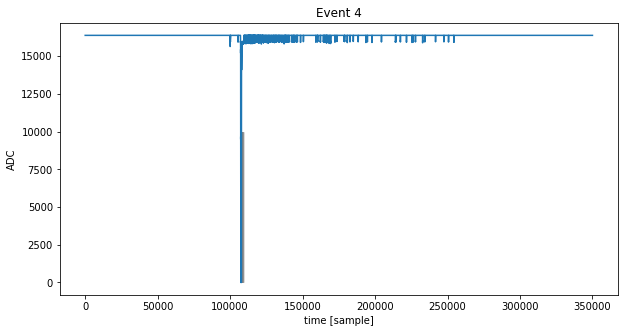

In [14]:
%matplotlib inline
event = NG.get_single_event(4)

t, ts, channellist, minchannel = Waveform(4)

figs, ax = plt.subplots(figsize = (10.,5.))
ax.plot(t, ts[0], label='Channel 0')
#ax[1].plot(t, ts[1], label='Bottom PMT', color='orange')
ax.set_ylabel("ADC")
#ax[1].set_ylabel("ADC")
ax.set_xlabel("time [sample]")
ax.set_title('Event ' + str(event.event_number))


for p in event.pulses:
    (ch, q, width, t0) = process_waveform(p)
    if q < 0:
        print(ch, ": ", q, width, t0)
        ax.add_patch(patches.Rectangle((p.left, 0), width, 10000, color='grey', alpha=0.2))